In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 200
NUM_CLASSES = 5

# Train: Heavy augmentation (Rotation, Shift, Zoom/Crop, Flip, Brightness)
train_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # Ensure 1 channel
    transforms.Resize((224, 224)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # shift width/height
    transforms.ColorJitter(brightness=0.2), # brightness 0.8-1.2
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # Converts to [0,1]
])

# Val: No augmentation, just resize and rescale
val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [6]:
train_dir = '/kaggle/input/koa-xray/XRAY/train'
val_dir = '/kaggle/input/koa-xray/XRAY/val'      

# Load Datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Training samples: 5779
Validation samples: 856


# Custom CNN Architecture

In [22]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(CustomCNN, self).__init__()
        
        # Block 1 (Input: 224x224 -> Output: 112x112)
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )
        
        # Block 2 (Input: 112x112 -> Output: 56x56)
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.30)
        )
        
        # Block 3 (Input: 56x56 -> Output: 28x28)
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.35)
        )

        # Block 4 (Input: 28x28 -> Output: 14x14)
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.40) # Higher dropout deeper in the network
        )
        
        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x) 
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

# Initialize Model
model = CustomCNN(num_classes=NUM_CLASSES).to(device)

In [8]:
# Calculate Class Weights 
y_train_indices = train_dataset.targets
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_indices), y=y_train_indices)

# Convert to Tensor and move to GPU
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class Weights: {class_weights}")

# Loss Function and Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Class Weights: [0.5055993  1.10497132 0.76240106 1.52480211 6.68092486]


Training Loop

In [9]:
# Define the Training Step
def train_one_epoch(model, loader, criterion, optimizer):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Stats
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    return running_loss / len(loader), 100 * correct / total

# Define the Validation Step
def validate(model, loader, criterion):
    model.eval() # Set model to evaluation mode (no dropout)
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad(): # Don't calculate gradients for validation
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss / len(loader), 100 * correct / total

In [28]:
import copy

# --- CONFIGURATION ---
PATIENCE = 10          # Stop if no improvement for 10 epochs
BEST_MODEL_PATH = 'best_model.pth'

# --- EARLY STOPPING CLASS ---
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.prev_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss > self.prev_loss:
            self.counter += 1
        else:
            self.counter = 0
        
        # Update previous loss for next comparison
        self.prev_loss = val_loss

        if self.counter >= self.patience:
            self.early_stop = True


# Initialize our new specific helper classes
divergence_stopper = EarlyStopping(patience=PATIENCE)
best_loss_so_far = float('inf') # To track when to save weights

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print(f"Starting Training...")

# --- 3. TRAINING LOOP ---
for epoch in range(EPOCHS):
    # Train & Validate
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Store History
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")
    
    # --- A. SAVE BEST WEIGHTS ---
    if val_loss < best_loss_so_far:
        best_loss_so_far = val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f" New best model found! Saved. (Loss: {val_loss:.4f})")
    
    # --- B. CHECK STOPPING CRITERIA ---
    divergence_stopper(val_loss)
    
    if divergence_stopper.early_stop:
        print("Early stopping triggered!")
        break

# --- 4. RELOAD BEST WEIGHTS ---
if os.path.exists(BEST_MODEL_PATH):
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
    print("Loaded best model weights.")

Starting Training...
Epoch [1/200] Train Loss: 1.6083 Acc: 24.99 | Val Loss: 1.5876 Acc: 27.92%
 New best model found! Saved. (Loss: 1.5876)
Epoch [2/200] Train Loss: 1.6080 Acc: 38.19 | Val Loss: 1.5761 Acc: 27.92%
 New best model found! Saved. (Loss: 1.5761)
Epoch [3/200] Train Loss: 1.6084 Acc: 29.36 | Val Loss: 1.5873 Acc: 27.92%
Epoch [4/200] Train Loss: 1.6072 Acc: 31.18 | Val Loss: 1.5783 Acc: 38.67%
Epoch [5/200] Train Loss: 1.6076 Acc: 34.90 | Val Loss: 1.5806 Acc: 38.67%
Epoch [6/200] Train Loss: 1.6075 Acc: 37.74 | Val Loss: 1.5983 Acc: 27.92%
Epoch [7/200] Train Loss: 1.6077 Acc: 31.35 | Val Loss: 1.5727 Acc: 38.67%
 New best model found! Saved. (Loss: 1.5727)
Epoch [8/200] Train Loss: 1.6195 Acc: 26.54 | Val Loss: 1.5993 Acc: 27.92%
Epoch [9/200] Train Loss: 1.6090 Acc: 30.82 | Val Loss: 1.6032 Acc: 17.87%
Epoch [10/200] Train Loss: 1.6081 Acc: 20.04 | Val Loss: 1.5958 Acc: 19.04%
Epoch [11/200] Train Loss: 1.6080 Acc: 23.34 | Val Loss: 1.5960 Acc: 24.42%
Epoch [12/200] Tr

In [ ]:
model = CustomCNN(num_classes=5).to(device) 
checkpoint_path = '../input/my-koa-model/best_model.pth' 

if os.path.exists(checkpoint_path):
    print(f"Loading weights from {checkpoint_path}...")
    model.load_state_dict(torch.load(checkpoint_path))
    print("Weights loaded successfully!")
else:
    print("No checkpoint found.")

Evaluation


Classification Report:

              precision    recall  f1-score   support

           0     0.6990    0.8066    0.7489       331
           1     0.3245    0.3203    0.3224       153
           2     0.7273    0.6025    0.6590       239
           3     0.7579    0.6792    0.7164       106
           4     0.7667    0.8519    0.8070        27

    accuracy                         0.6484       856
   macro avg     0.6551    0.6521    0.6508       856
weighted avg     0.6494    0.6484    0.6454       856



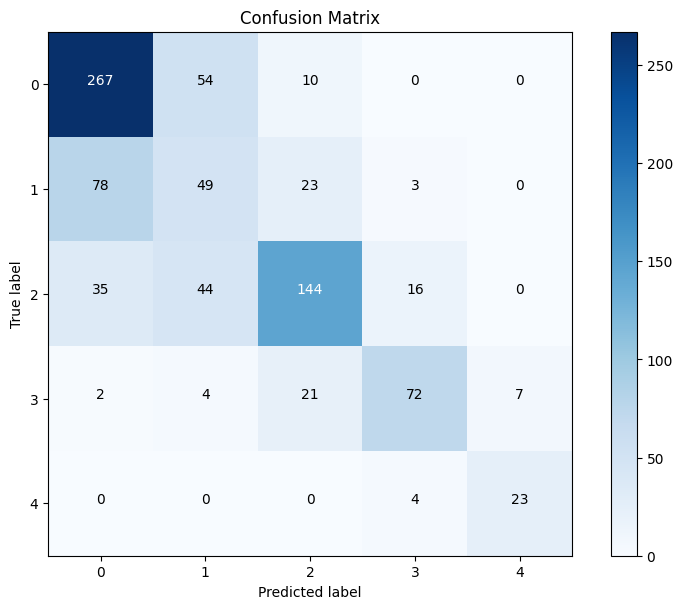

In [34]:
# 1. Get all predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# 2. Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, digits=4))

# 3. Confusion Matrix Plot
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, classes=['0', '1', '2', '3', '4'])

# AlexNet
Slightly modified for training and evaluation

In [26]:
class AlexNet_KOA(nn.Module):
    def __init__(self, num_classes=5):
        super(AlexNet_KOA, self).__init__()
        
        # Feature Extractor
        self.features = nn.Sequential(
            # Conv 1
            nn.Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Conv 2
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Conv 3
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Conv 4
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Conv 5
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # Global Average Pooling (Modern adjustment to reduce parameters)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        # Classifier Head
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# 2. Initialize
model = AlexNet_KOA(num_classes=5).to(device)

# 3. Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4) 

# 4. Loss Function (Keep using your weighted loss!)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

print("AlexNet initialized for KOA benchmarking!")

AlexNet initialized for KOA benchmarking!


# DenseNet
pre-trained on ImageNet, will be trained on our dataset

In [30]:
# Run this BEFORE the DenseNet block
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3), # <--- MUST BE 3 FOR DENSENET
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3), # <--- MUST BE 3
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Re-load data with new transforms
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# --- CONFIGURATION ---
# If you hit Out Of Memory (OOM), change BATCH_SIZE to 16
EPOCHS = 100
PATIENCE = 10
DENSENET_PATH = 'densenet121_best.pth'

# 1. DEFINE DENSENET BUILDER
def get_densenet(num_classes=5):
    # Load Pretrained DenseNet121
    # weights="DEFAULT" downloads the best available ImageNet weights
    model = models.densenet121(weights="DEFAULT")
    
    # UNFREEZE: We want to fine-tune the whole model for X-rays
    # (No need to set requires_grad=False)
    
    # Replace the Classifier
    # DenseNet's classifier is a linear layer named 'classifier'
    num_ftrs = model.classifier.in_features
    
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    
    return model

# 2. INITIALIZE
print("Initializing DenseNet121...")
model = get_densenet(num_classes=5).to(device)

# 3. OPTIMIZER & LOSS
# DenseNet is deep and complex. 
# We use a lower Learning Rate (1e-4) to carefully fine-tune the pretrained weights.
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# 4. HELPERS
divergence_stopper = EarlyStopping(patience=PATIENCE)
best_loss_so_far = float('inf')
history_densenet = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

# 5. TRAINING LOOP
print(f"Starting DenseNet Training (Saving to: {DENSENET_PATH})...")

for epoch in range(EPOCHS):
    # Train & Validate
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Log
    history_densenet['train_loss'].append(train_loss)
    history_densenet['train_acc'].append(train_acc)
    history_densenet['val_loss'].append(val_loss)
    history_densenet['val_acc'].append(val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")
    
    # --- SAVE BEST ---
    if val_loss < best_loss_so_far:
        best_loss_so_far = val_loss
        torch.save(model.state_dict(), DENSENET_PATH)
        print(f" New best found! Saved. (Loss: {val_loss:.4f})")
    
    # --- STOPPING ---
    divergence_stopper(val_loss)
    if divergence_stopper.early_stop:
        print("Early stopping triggered!")
        break

# 6. RELOAD BEST
if os.path.exists(DENSENET_PATH):
    model.load_state_dict(torch.load(DENSENET_PATH))
    print("Loaded best DenseNet weights.")

Initializing DenseNet121...
Starting DenseNet Training (Saving to: densenet121_best.pth)...
Epoch [1/100] Train Loss: 1.3210 Acc: 35.65% | Val Loss: 1.0789 Acc: 56.19%
 New best found! Saved. (Loss: 1.0789)
Epoch [2/100] Train Loss: 0.9299 Acc: 53.87% | Val Loss: 0.9617 Acc: 58.29%
 New best found! Saved. (Loss: 0.9617)
Epoch [3/100] Train Loss: 0.8704 Acc: 56.60% | Val Loss: 0.9338 Acc: 57.71%
 New best found! Saved. (Loss: 0.9338)
Epoch [4/100] Train Loss: 0.8128 Acc: 59.70% | Val Loss: 1.0059 Acc: 55.84%
Epoch [5/100] Train Loss: 0.7577 Acc: 61.29% | Val Loss: 0.8908 Acc: 61.10%
 New best found! Saved. (Loss: 0.8908)
Epoch [6/100] Train Loss: 0.7824 Acc: 61.69% | Val Loss: 0.8879 Acc: 61.68%
 New best found! Saved. (Loss: 0.8879)
Epoch [7/100] Train Loss: 0.7175 Acc: 62.78% | Val Loss: 0.9082 Acc: 58.06%
Epoch [8/100] Train Loss: 0.7046 Acc: 65.27% | Val Loss: 0.8931 Acc: 60.05%
Epoch [9/100] Train Loss: 0.6691 Acc: 65.88% | Val Loss: 0.8284 Acc: 63.79%
 New best found! Saved. (Loss

# TorchXRayVision
DenseNet + ResNet trained specifically on 200K+ XRays (mostly chest)

In [5]:
# 1. Install (Run once)
!pip install torchxrayvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 65.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 5.4 MB/s eta 0:00:000:00:0100:01
  Attempting un

In [11]:
import torchxrayvision as xrv


def get_xray_model(num_classes=5):
    # Load model pre-trained on ALL major chest datasets
    model = xrv.models.DenseNet(weights="densenet121-res224-all")
    
    # This prevents the model from trying to normalize outputs based on old classes
    model.op_threshs = None
    
    # Replace Classifier
    # Note: xrv models output a specific dictionary, but we can hack the classifier
    num_ftrs = model.classifier.in_features
    
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
    return model

# 2. TRANSFORM ADAPATION (CRITICAL)
# XRV expects 1-channel input, but distinct normalization
xray_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # DO NOT USE ImageNet Normalize ([0.485...])
    # XRV handles raw pixel values better, or we can just leave it as 0-1
])

# 3. Initialize
model = get_xray_model(num_classes=5)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
import copy

# --- CONFIGURATION ---
PATIENCE = 10          # Stop if no improvement for 10 epochs
BEST_MODEL_PATH = 'best_model_txv.pth'

# --- EARLY STOPPING CLASS ---
class EarlyStopping:
    def __init__(self, patience=10):
        self.patience = patience
        self.counter = 0
        self.prev_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss > self.prev_loss:
            self.counter += 1
        else:
            self.counter = 0
        
        # Update previous loss for next comparison
        self.prev_loss = val_loss

        if self.counter >= self.patience:
            self.early_stop = True


# Initialize our new specific helper classes
divergence_stopper = EarlyStopping(patience=PATIENCE)
best_loss_so_far = float('inf') # To track when to save weights

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

print(f"Starting Training...")

# --- 3. TRAINING LOOP ---
for epoch in range(EPOCHS):
    # Train & Validate
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    # Store History
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.2f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%")
    
    # --- A. SAVE BEST WEIGHTS ---
    if val_loss < best_loss_so_far:
        best_loss_so_far = val_loss
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f" New best model found! Saved. (Loss: {val_loss:.4f})")
    
    # --- B. CHECK STOPPING CRITERIA ---
    divergence_stopper(val_loss)
    
    if divergence_stopper.early_stop:
        print("Early stopping triggered!")
        break

# --- 4. RELOAD BEST WEIGHTS ---
if os.path.exists(BEST_MODEL_PATH):
    model.load_state_dict(torch.load(BEST_MODEL_PATH))
    print("Loaded best model weights.")

Starting Training...
Epoch [1/200] Train Loss: 1.5834 Acc: 32.88 | Val Loss: 1.4339 Acc: 42.99%
 New best model found! Saved. (Loss: 1.4339)
Epoch [2/200] Train Loss: 1.3762 Acc: 39.92 | Val Loss: 1.2103 Acc: 45.91%
 New best model found! Saved. (Loss: 1.2103)
Epoch [3/200] Train Loss: 1.1730 Acc: 45.09 | Val Loss: 1.1915 Acc: 43.69%
 New best model found! Saved. (Loss: 1.1915)
Epoch [4/200] Train Loss: 1.0899 Acc: 46.96 | Val Loss: 1.1366 Acc: 51.40%
 New best model found! Saved. (Loss: 1.1366)
Epoch [5/200] Train Loss: 1.0132 Acc: 49.70 | Val Loss: 1.3318 Acc: 40.77%
Epoch [6/200] Train Loss: 0.9542 Acc: 51.62 | Val Loss: 1.3347 Acc: 43.46%
Epoch [7/200] Train Loss: 0.9501 Acc: 53.11 | Val Loss: 1.0522 Acc: 53.62%
 New best model found! Saved. (Loss: 1.0522)
Epoch [8/200] Train Loss: 0.9173 Acc: 53.43 | Val Loss: 1.0198 Acc: 56.89%
 New best model found! Saved. (Loss: 1.0198)
Epoch [9/200] Train Loss: 0.8953 Acc: 54.68 | Val Loss: 0.9991 Acc: 57.71%
 New best model found! Saved. (Los

In [1]:
# 1. Get all predictions
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# 2. Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, digits=4))

# 3. Confusion Matrix Plot
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, classes=['0', '1', '2', '3', '4'])

NameError: name 'model' is not defined